<a href="https://colab.research.google.com/github/yarenkarakulak/Makine_Ogrenmesi_Ile_Hastalik_Tahmini/blob/main/Hasta_Yatis_Suresi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# Ankara(1), İstanbul(2), İzmir(3) -> label encoding : herhangi bir değer belirtmez
#iyi, orta, kötü, çok kötü -> onehot encoding: hepsine rastgele sayı verilmez ya iyi 4 our ya da çok kötü

#load dataset

In [60]:
df= pd.read_csv("/content/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2021_20231012.csv (3).zip")


df.info()

<ipython-input-60-86bd73a6f13c>:1: DtypeWarning: Columns (10,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv("/content/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2021_20231012.csv (3).zip")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101588 entries, 0 to 2101587
Data columns (total 33 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Hospital Service Area                object 
 1   Hospital County                      object 
 2   Operating Certificate Number         float64
 3   Permanent Facility Id                float64
 4   Facility Name                        object 
 5   Age Group                            object 
 6   Zip Code - 3 digits                  object 
 7   Gender                               object 
 8   Race                                 object 
 9   Ethnicity                            object 
 10  Length of Stay                       object 
 11  Type of Admission                    object 
 12  Patient Disposition                  object 
 13  Discharge Year                       int64  
 14  CCSR Diagnosis Code                  object 
 15  CCSR Diagnosis Description      

In [ ]:
los = df["Length of Stay"]
df["Length of Stay"] = df["Length of Stay"].replace({"120+": 120, "120 +": 120})
df["Length of Stay"] = pd.to_numeric(df["Length of Stay"])

df.isna().sum()

for column in df.columns:
    unique_values = df[column].nunique()  # Burada len() kaldırıldı
    print(f"Number of unique values in {column}: {unique_values}")

df = df[df["Patient Disposition"] != "Expired"] # Muhtemel yazım hatası düzeltildi


Number of unique values in Hospital Service Area: 8
Number of unique values in Hospital County: 57
Number of unique values in Operating Certificate Number: 168
Number of unique values in Permanent Facility Id: 205
Number of unique values in Facility Name: 205
Number of unique values in Age Group: 5
Number of unique values in Zip Code - 3 digits: 50
Number of unique values in Gender: 3
Number of unique values in Race: 4
Number of unique values in Ethnicity: 4
Number of unique values in Length of Stay: 120
Number of unique values in Type of Admission: 6
Number of unique values in Patient Disposition: 19
Number of unique values in Discharge Year: 1
Number of unique values in CCSR Diagnosis Code: 477
Number of unique values in CCSR Diagnosis Description: 477
Number of unique values in CCSR Procedure Code: 320
Number of unique values in CCSR Procedure Description: 320
Number of unique values in APR DRG Code: 334
Number of unique values in APR DRG Description: 334
Number of unique values in 

#EDA

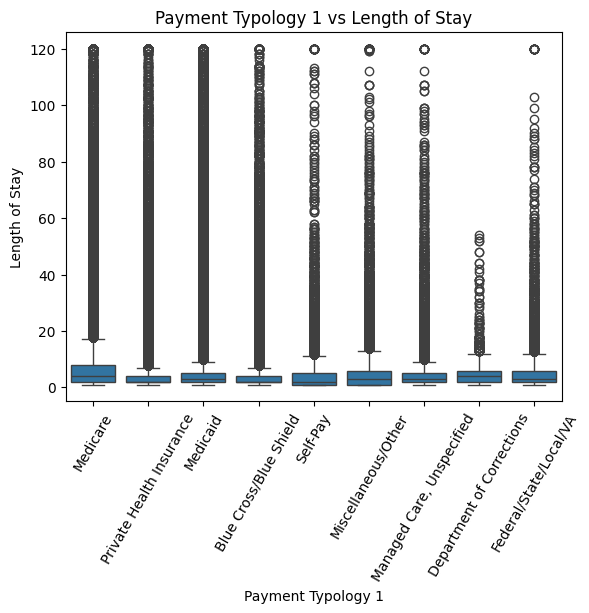

In [ ]:
sns.boxplot(x= "Payment Typology 1", y ="Length of Stay", data = df )
plt.title ("Payment Typology 1 vs Length of Stay")
plt.xticks(rotation=60)
plt.show()

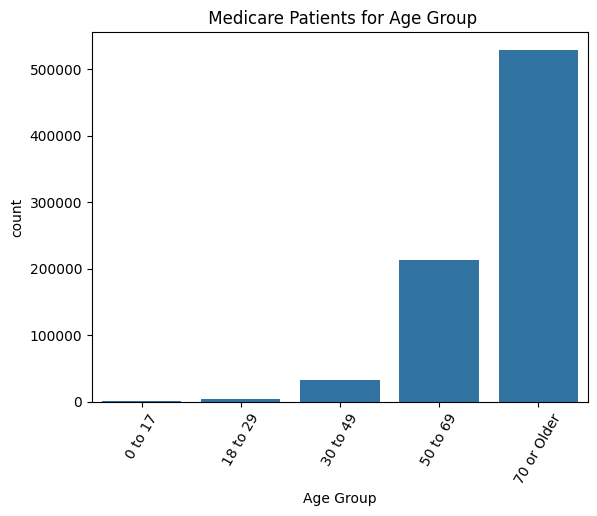

In [ ]:
sns.countplot(x= "Age Group", data = df[df["Payment Typology 1"] == "Medicare"] , order=["0 to 17","18 to 29", "30 to 49", "50 to 69", "70 or Older" ])
plt.title (" Medicare Patients for Age Group")
plt.xticks(rotation=60)
plt.show()

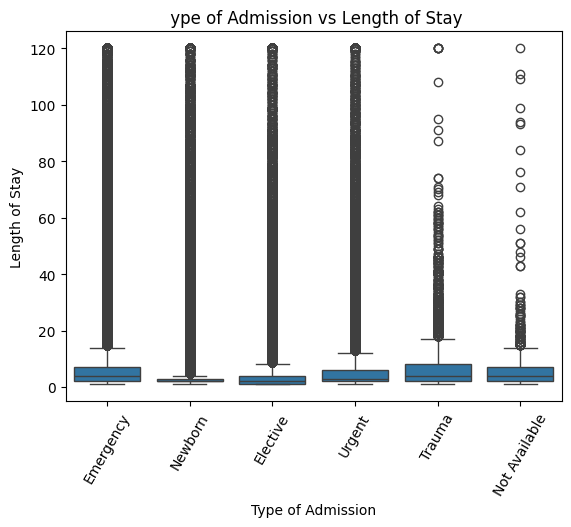

In [ ]:
sns.boxplot(x= "Type of Admission", y ="Length of Stay", data = df )
plt.title (" ype of Admission vs Length of Stay")
plt.xticks(rotation=60)
plt.show()

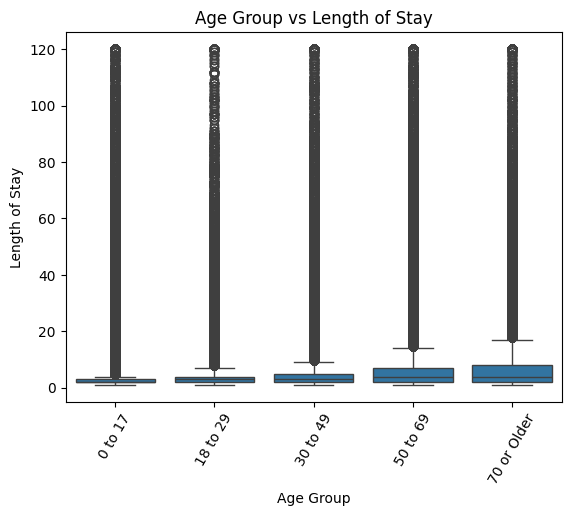

In [ ]:
sns.boxplot(x= "Age Group", y ="Length of Stay", data = df, order=["0 to 17","18 to 29", "30 to 49", "50 to 69", "70 or Older" ])
plt.title ("Age Group vs Length of Stay")
plt.xticks(rotation=60)
plt.show()

#Feature Encoding/ Label Encoding

In [74]:
# Get the current columns in the DataFrame
current_columns = df.columns.tolist()

# Columns to drop
columns_to_drop = ["Hospital Service Area","Operating Certificate Number", "Facility Name", "Zip Code - 3 digits", "Patient Disposition", "Discharge Year", "CCSR Diagnosis Code", "CCSR Procedure Description", "APR DRG Description", "APR MDC Description", "Birth Weight" , "Payment Typology 2", "Payment Typology 3","Total Charges", "Total Costs"]

# Find the valid columns to drop (intersection of current columns and columns to drop)
valid_columns_to_drop = list(set(current_columns) & set(columns_to_drop))

# Drop only the valid columns
df = df.drop(columns=valid_columns_to_drop, axis=1)

age_group_index = {"0 to 17": 0, "18 to 29": 1, "30 to 49": 2, "50 to 69": 3, "70 or Older": 4}
gender_index = {"U":0, "Female": 1, "Male": 2} # Added 'M' to gender_index
risk_and_severity_index = {np.nan:0, "Minor": 1, "Modarate": 2, "Major": 3, "Extreme": 4}

# Apply the mapping only once to "Age Group"
df["Age Group"] = df["Age Group"].apply(lambda x: age_group_index.get(x, x)) # Use get to handle missing keys

# Apply the mapping to "Gender" with error handling
df["Gender"] = df["Gender"].apply(lambda x: gender_index.get(x, np.nan))


encoder= OrdinalEncoder()
df["Race"] = encoder.fit_transform(np.asarray(df["Race"]).reshape(-1,1))

df["Ethnicity"] = encoder.fit_transform(np.asarray(df["Ethnicity"]).reshape(-1,1))

df["Type of Admission"] = encoder.fit_transform(np.asarray(df["Type of Admission"]).reshape(-1,1))

df["CCSR Diagnosis Code"] = encoder.fit_transform(np.asarray(df["CCSR Diagnosis Code"]).reshape(-1,1))

df["CCSR Procedure Code"] = encoder.fit_transform(np.asarray(df["CCSR Procedure Code"]).reshape(-1,1))

df.isna().sum()



,0
Hospital County,10642
Permanent Facility Id,10642
Age Group,0
Gender,2101588
Race,0
Ethnicity,0
Length of Stay,0
Type of Admission,0
CCSR Diagnosis Code,1634
CCSR Procedure Code,576021


#Missing Value Kontrolü

In [79]:
df = df.dropna(subset=["CCSR Diagnosis Code", "CCSR Procedure Code","Permanent Facility Id", "Hospital County"  ])
df.isna().sum()

,0
Hospital County,0
Permanent Facility Id,0
Age Group,0
Gender,1518143
Race,0
Ethnicity,0
Length of Stay,0
Type of Admission,0
CCSR Diagnosis Code,0
CCSR Procedure Code,0


Train/ Test Split

In [92]:
x= df.drop(["Length of Stay"], axis=1)
y= df["Length of Stay"]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#Regression: Train ve test

In [95]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# "120 +" gibi string değerleri sayısal 120'ye dönüştürme
y_train = y_train.replace("120 +", 120)
y_test = y_test.replace("120 +", 120)

# LabelEncoder kullanarak 'Kings' gibi metin değerlerini sayısal verilere dönüştürme
label_encoder = LabelEncoder()

# x_train ve x_test içindeki tüm kategorik sütunları sayısal verilere dönüştürme
for column in x_train.select_dtypes(include=['object']).columns:
    x_train[column] = label_encoder.fit_transform(x_train[column].astype(str))
    x_test[column] = label_encoder.transform(x_test[column].astype(str))  # Test verisini de aynı şekilde dönüştürmeliyiz

# Modeli oluştur ve eğit
dtree = DecisionTreeRegressor(max_depth=10)
dtree.fit(x_train, y_train)

# Test ve eğitim seti için tahminler
test_pred = dtree.predict(x_test)
train_pred = dtree.predict(x_train)

# MSE hesaplama
print("Test MSE:", mean_squared_error(y_test, test_pred))
print("Train MSE:", mean_squared_error(y_train, train_pred))


Test MSE: 48.85715982379759
Train MSE: 46.424757447573405


#Kategorik Hale Getirme : solve classification problem: train ve test

<Axes: xlabel='los_bin', ylabel='count'>

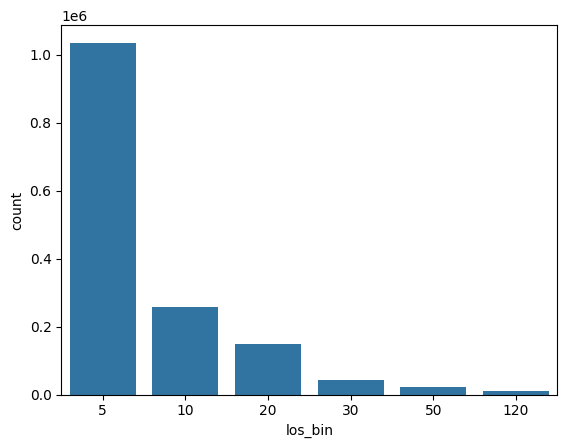

In [104]:
# Length of Stay sütununu sayısal verilere dönüştürme
df["Length of Stay"] = pd.to_numeric(df["Length of Stay"], errors='coerce')

# Bin aralıklarını tanımla
bins = [0, 5, 10, 20, 30, 50, 120]
labels = [5, 10, 20, 30, 50, 120]

# Length of Stay verilerini binlere ayırma
df["los_bin"] = pd.cut(x=df["Length of Stay"], bins=bins, labels=labels, include_lowest=True, duplicates='drop')
df["los_label"] = pd.cut(x=df["Length of Stay"], bins=bins, labels=labels, include_lowest=True, duplicates='drop')

f, ax = plt.subplots()
sns.countplot (x= "los_bin", data = df)

In [112]:
new_x = df.drop(["Length of Stay", "los_bin", "los_label"], axis=1)
new_y = df["los_label"]

x_train, x_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.2, random_state=42)

y_train = y_train.fillna(y_train.mode()[0])  # NaN değerleri en sık geçen değerle doldur
y_train = y_train.astype(str).astype('category').cat.codes  # Kategorik verileri sayısala çevir

# y_test'teki NaN değerlerini en sık geçen değerle doldur
y_test = y_test.fillna(y_test.mode()[0])

# Apply label encoding to categorical features in x_train and x_test
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for column in x_train.select_dtypes(include=['object']).columns:
    x_train[column] = label_encoder.fit_transform(x_train[column].astype(str))
    x_test[column] = label_encoder.transform(x_test[column].astype(str))

dtree = DecisionTreeClassifier(max_depth=10)
dtree.fit(x_train, y_train)

train_prediction = dtree.predict(x_train)
test_prediction = dtree.predict(x_test)

print("Train Accuracy: ", accuracy_score(y_train, train_prediction))
print("Test Accuracy: ", accuracy_score(y_test, test_prediction))
print("Classification Report: ", classification_report(y_test, test_prediction))


Train Accuracy:  0.7117554840866388
Test Accuracy:  0.00012515273573999848
Classification Report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.03      0.00      0.00    207478
          10       0.00      0.00      0.00     51403
          20       0.00      0.00      0.00     29668
          30       0.00      0.00      0.00      8568
          50       0.00      0.00      0.00      4547
         120       0.00      0.00      0.00      1965

    accuracy                           0.00    303629
   macro avg       0.00      0.00      0.00    303629
weighted avg       0.02      0.00      0.00    303629



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_